In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Data sets

### Sine wave

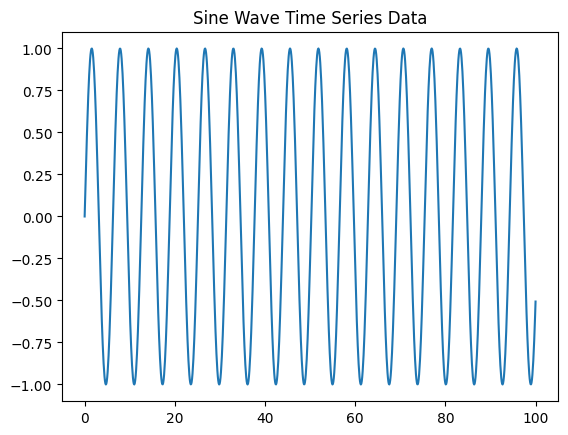

In [ ]:
# Generate synthetic time series data (sine wave)
time_steps = np.linspace(0, 100, 1000)
data = np.sin(time_steps)

# Plot the data
plt.plot(time_steps, data)
plt.title("Sine Wave Time Series Data")
plt.show()


### Seasonality and Trend

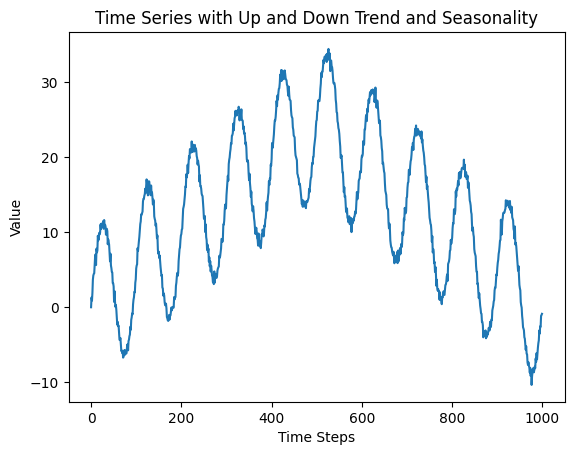

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate time series with seasonality and a unidirectional trend that reverses
def generate_seasonal_up_down_trend_data(n_steps=1000, trend_slope=0.05, seasonality_amplitude=5, seasonality_period=100, noise_factor=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)  # For reproducibility

    # Generate trend: increasing for the first half, decreasing for the second half
    trend = np.zeros(n_steps)
    midpoint = n_steps // 2
    trend[:midpoint] = np.arange(midpoint) * trend_slope  # Upward trend
    trend[midpoint:] = trend_slope * (midpoint - np.arange(midpoint))  # Downward trend

    # Generate seasonality (sine wave pattern)
    time = np.arange(n_steps)
    seasonality = seasonality_amplitude * np.sin(2 * np.pi * time / seasonality_period)

    # Add random noise
    noise = np.random.normal(0, noise_factor, n_steps)

    # Combine trend, seasonality, and noise
    data = trend + seasonality + noise

    return data

# Generate time series data with up and down trend and seasonality
n_steps = 1000
data = generate_seasonal_up_down_trend_data(n_steps=n_steps,
                                             trend_slope=0.05,
                                             seasonality_amplitude=10,
                                             seasonality_period=100,
                                             noise_factor=0.5)

# Plot the generated data
plt.plot(data)
plt.title("Time Series with Up and Down Trend and Seasonality")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.show()


### Random-walk

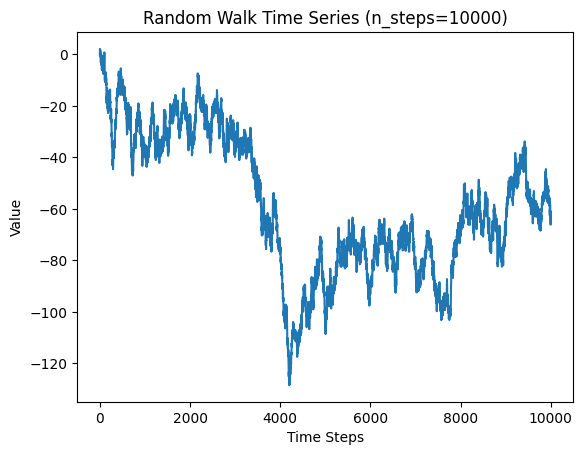

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate random walk
def generate_random_walk(n_steps=1000, noise_factor=0.2, seed=None):
    if seed is not None:
        np.random.seed(seed)  # For reproducibility

    # Initialize random walk with starting value at 0
    steps = [0]

    for i in range(1, n_steps):
        # Generate a random step: -1 or 1, plus some Gaussian noise
        step = steps[-1] + np.random.choice([-1, 1]) + np.random.normal(0, noise_factor)
        steps.append(step)

    return np.array(steps)

# Generate random walk with noise
n_steps = 10000
data = generate_random_walk(n_steps=n_steps, noise_factor=0.5, seed=77)

# Plot the random walk
plt.plot(data)
plt.title(f"Random Walk Time Series (n_steps={n_steps})")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.show()


In [ ]:
data.shape

(10, 100)

### Concept drift

(2000,)


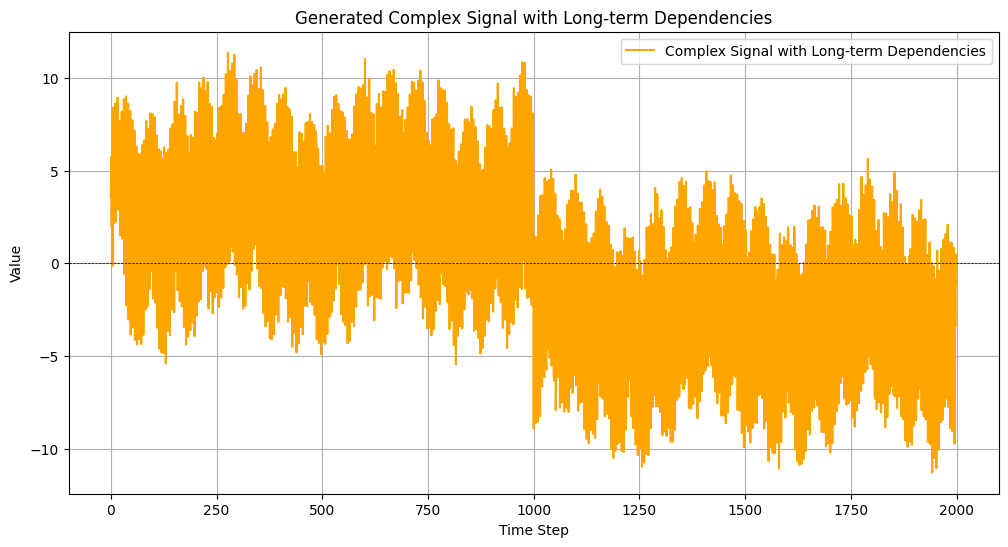

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_complex_signal(seq_length=1000, dependency_steps=100, noise_factor=0.5, seed=None):
    if seed is not None:
        np.random.seed(seed)

    data = np.zeros(seq_length)


    # Time variable
    t = np.arange(seq_length)

    # Generate oscillatory patterns
    sine_wave1 = np.sin(.1 * t)  # Low frequency
    sine_wave2 = np.sin(1.3 * t)  # Medium frequency
    sine_wave3 = np.sin(2.5 * t)  # High frequency

    # Create a complex signal by combining the sine waves
    base_signal = sine_wave1*1.82 + sine_wave2 * 2.2 + 2 * sine_wave3

    # Introduce long-term dependencies by shifting the base signal
    long_term_dependency = np.roll(base_signal, dependency_steps)  # Shift by dependency steps
    long_term_dependency[:dependency_steps] = 0  # Avoid wrapping effects at the beginning

    # Create a trend that changes periodically
    trend = np.zeros(seq_length)
    trend[:seq_length//2] = 3  # Positive trend for the first half
    trend[seq_length//2:] = -3  # Negative trend for the second half

    # Combine all components into one complex signal
    data = base_signal + long_term_dependency + trend + noise_factor * np.random.randn(seq_length)

    return data

# Generate the complex signal
data = create_complex_signal(seq_length=2000, dependency_steps=30)
print(data.shape)
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(data, label='Complex Signal with Long-term Dependencies', color='orange')
plt.title('Generated Complex Signal with Long-term Dependencies')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.grid()
plt.legend()
plt.show()


# Preprocessing

### Train-Val-Test Split

In [ ]:
n_sequences = data.shape[0]

if n_sequences > 5:
  train_size = int(0.4 * n_sequences)   # 70% for training
  val_size = int(0.4 * n_sequences)    # 15% for validation
  test_size = n_sequences - train_size - val_size  # 15% for testing

  # Split the data
  train_data = data[:train_size]
  val_data = data[train_size:train_size + val_size]
  test_data = data[train_size + val_size:]
else:
  train_data = data
  val_data = data
  test_data = data
# Check the shapes of the splits
print(f"Training Data Shape: {train_data.shape}")
print(f"Validation Data Shape: {val_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

Training Data Shape: (4000,)
Validation Data Shape: (4000,)
Test Data Shape: (2000,)


### Prep data

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
def prepare_input_output(data, input_steps, output_steps=1):
    X, y = [], []
    for t in range(len(data) - input_steps - output_steps + 1):
        X.append(data[t:t + input_steps])  # Input
        y.append(data[t + input_steps:t + input_steps + output_steps])  # Output
    return np.array(X), np.array(y)

# Define the number of input time steps
input_steps = 20  # last N time steps to predict the next value

# Prepare training, validation, and test sets
X_train, y_train = prepare_input_output(train_data, input_steps)
X_val, y_val = prepare_input_output(val_data, input_steps)
X_test, y_test = prepare_input_output(test_data, input_steps)

# Check the shapes of the prepared input-output pairs
print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f"X_val Shape: {X_val.shape}, y_val Shape: {y_val.shape}")
print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

# Rescale data to [0, 1]
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Rescale and reshape the data for RNN
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape[0], X_train.shape[1], 1)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)

X_val_scaled = scaler_X.transform(X_val.reshape(-1, 1)).reshape(X_val.shape[0], X_val.shape[1], 1)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)

X_test_scaled = scaler_X.transform(X_test.reshape(-1, 1)).reshape(X_test.shape[0], X_test.shape[1], 1)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
# Create tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)

X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val_scaled)

X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

# Create a DataLoader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=500, shuffle=True)

# Check the shapes of the prepared input-output pairs
print(f"X_train_tensor Shape: {X_train_tensor.shape}, y_train Shape: {y_train.shape}")
print(f"X_val_tensor Shape: {X_val_tensor.shape}, y_val Shape: {y_val.shape}")
print(f"X_test_tensor Shape: {X_test_tensor.shape}, y_test Shape: {y_test.shape}")

X_train Shape: (3980, 20), y_train Shape: (3980, 1)
X_val Shape: (3980, 20), y_val Shape: (3980, 1)
X_test Shape: (1980, 20), y_test Shape: (1980, 1)
X_train_tensor Shape: torch.Size([3980, 20, 1]), y_train Shape: (3980, 1)
X_val_tensor Shape: torch.Size([3980, 20, 1]), y_val Shape: (3980, 1)
X_test_tensor Shape: torch.Size([1980, 20, 1]), y_test Shape: (1980, 1)


# Model

#### Custom RNN

In [ ]:
import torch
import torch.nn as nn

class CustomRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=25, output_size=1):
        super(CustomRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights
        self.weight_ih_l0 = nn.Parameter(torch.randn(hidden_size, input_size) * 0.01)  # (hidden_size, input_size)
        self.weight_hh_l0 = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.01)  # (hidden_size, hidden_size)

        # Biases should have shape (hidden_size,)
        self.bias_ih_l0 = nn.Parameter(torch.zeros(hidden_size))  # (hidden_size,)
        self.bias_hh_l0 = nn.Parameter(torch.zeros(hidden_size))  # (hidden_size,)

        # Linear layer (equivalent to nn.Linear)
        self.Wy = nn.Parameter(torch.randn(output_size, hidden_size) * 0.01)  # (output_size, hidden_size)
        self.by = nn.Parameter(torch.zeros(output_size))  # (output_size,)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        h = torch.zeros(batch_size, self.hidden_size)  # (batch_size, hidden_size)

        for t in range(seq_len):
            xt = x[:, t, :]  # (batch_size, input_size)

            # Fix matrix multiplication order
            h = torch.tanh(
                torch.matmul(xt, self.weight_ih_l0.T) + self.bias_ih_l0  # (batch_size, hidden_size)
                + torch.matmul(h, self.weight_hh_l0.T) + self.bias_hh_l0  # (batch_size, hidden_size)
            )

        # Fully connected layer (final projection)
        out = torch.matmul(h, self.Wy.T) + self.by  # (batch_size, output_size)
        return out


# Test the model
model = CustomRNN(input_size=1, hidden_size=10, output_size=1)
test_input = torch.randn(500, 10, 1)  # (batch_size=500, seq_len=10, input_size=1)
output = model(test_input)
print(output.shape)  # Expected: (500, 1)

# # Print the shapes of the weights and biases
# print(f"Weight Input-to-Hidden W: {model.weight_ih_l0}")
# print(f"Weight Hidden-to-Hidden U: {model.weight_hh_l0}")
# print(f"Bias Input-to-Hidden : {model.bias_ih_l0}")
# print(f"Bias Hidden-to-Hidden : {model.bias_hh_l0}")
# print(f"Bias Hidden-to-Output V : {model.Wy}")

torch.Size([500, 1])


#### PyTorch RNN

In [111]:
from torch.utils.data import DataLoader, TensorDataset

class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=25, output_size=1):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)  # out contains all hidden states
        out = out[:, -1, :]    # Take only the last output
        out = self.fc(out)
        return out
model = RNN(input_size=1, hidden_size=10, output_size=1)

# Fit model

### Loss function

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training loop

In [ ]:
gradients = []

# Training loop
for epoch in range(500):  # Example epoch count
    for batch_data, batch_targets in dataloader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(batch_data)  # Forward pass
        loss = criterion(outputs, batch_targets)  # Compute loss
        loss.backward()  # Backward pass

        # Store gradients for analysis
        grad_norm = 0
        for param in model.parameters():
            if param.grad is not None:
                grad_norm += param.grad.data.norm(2).item() ** 2  # L2 norm of gradients
        gradients.append(np.sqrt(grad_norm))  # Append the norm to the list

        optimizer.step()  # Update weights
    if (epoch + 1) % 50 == 0:
      print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.8f}')

### Visualize gradient decay

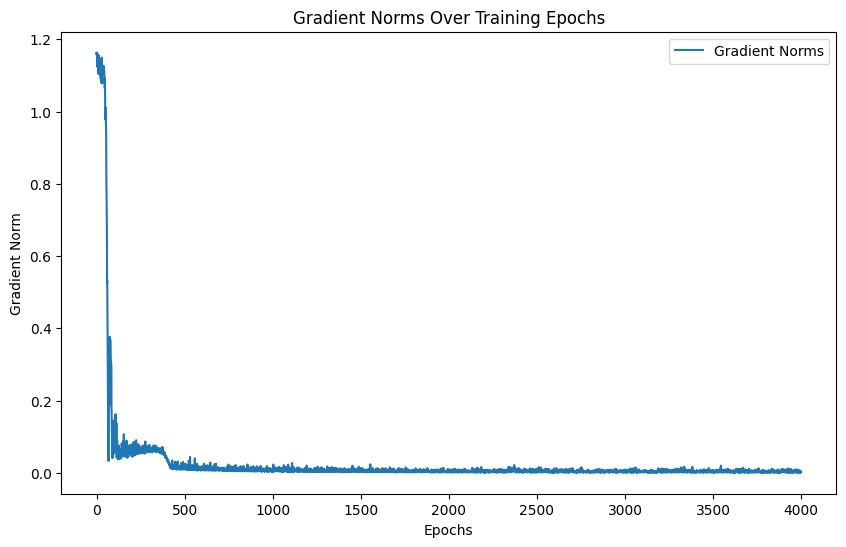

In [ ]:
# Plotting the gradient norms
plt.figure(figsize=(10, 6))
plt.plot(gradients, label='Gradient Norms')
plt.title('Gradient Norms Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()

### Training results

RMSE: 1.3614169392462678


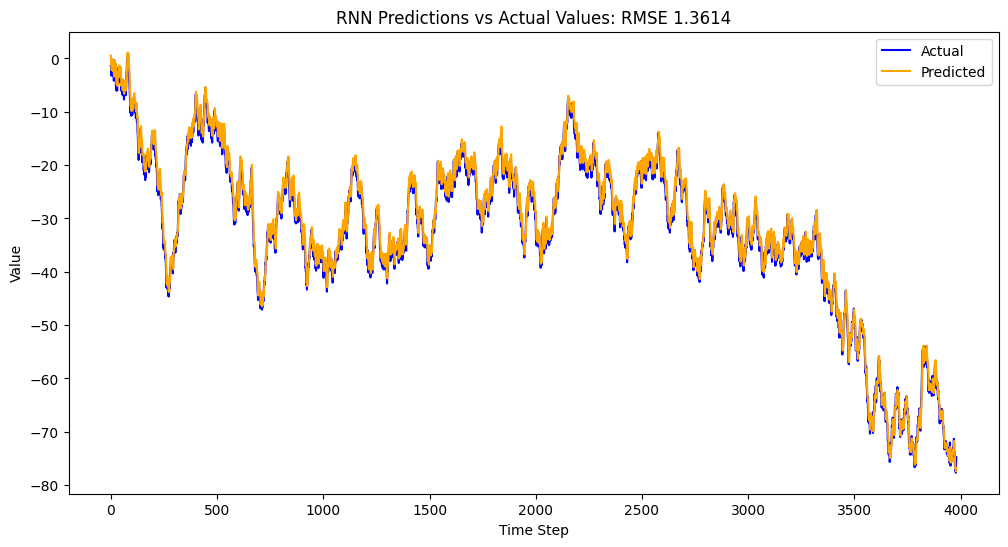

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_train_tensor)

y_hat = scaler_X.inverse_transform(predictions.numpy())
y = scaler_y.inverse_transform(y_train_tensor.reshape(-1, 1))

rmse = np.sqrt(np.mean((y - y_hat) ** 2))
print(f'RMSE: {rmse}')

import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual', color='blue')  # Actual values
plt.plot(y_hat, label='Predicted', color='orange')  # Predicted values
plt.title(f'RNN Predictions vs Actual Values: RMSE {rmse:.4f}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

## Eval predictions

RMSE: 1.3314377303685172


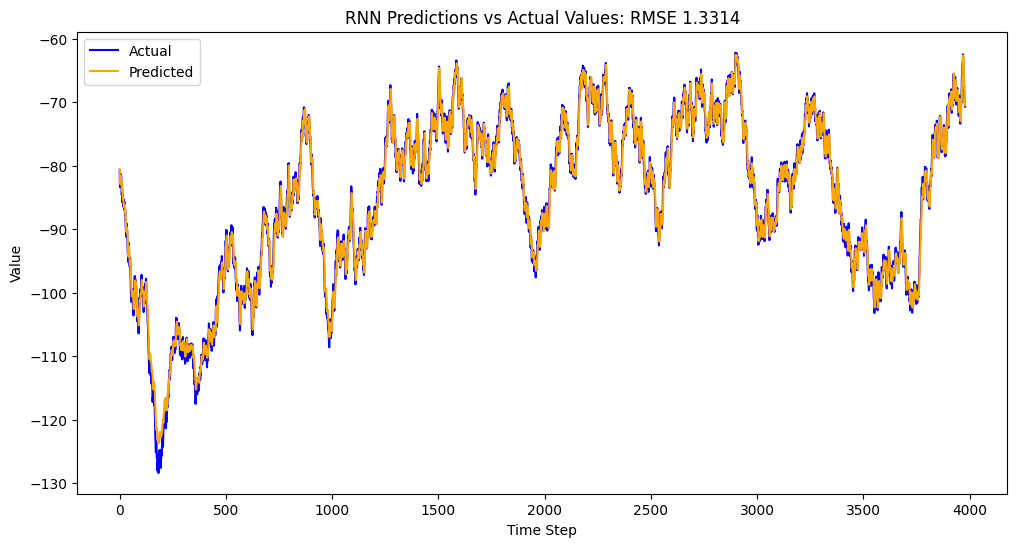

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_val_tensor)

y_hat = scaler_X.inverse_transform(predictions.numpy())
y = scaler_y.inverse_transform(y_val_tensor.reshape(-1, 1))

rmse = np.sqrt(np.mean((y - y_hat) ** 2))
print(f'RMSE: {rmse}')

import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual', color='blue')  # Actual values
plt.plot(y_hat, label='Predicted', color='orange')  # Predicted values
plt.title(f'RNN Predictions vs Actual Values: RMSE {rmse:.4f}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

## Test predictions

RMSE: 1.239693266825604


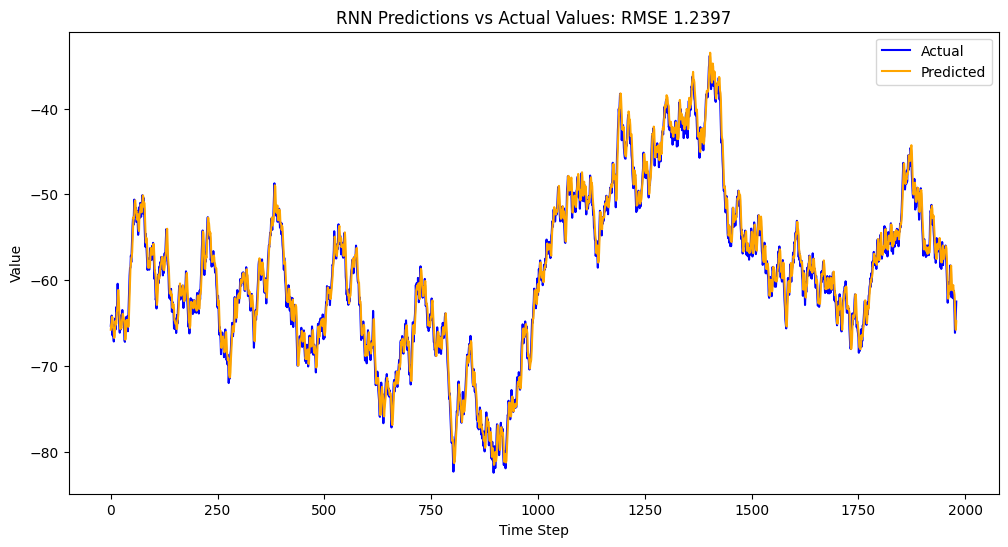

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_tensor)

y_hat = scaler_X.inverse_transform(predictions.numpy())
y = scaler_y.inverse_transform(y_test_tensor.reshape(-1, 1))

rmse = np.sqrt(np.mean((y - y_hat) ** 2))
print(f'RMSE: {rmse}')

import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual', color='blue')  # Actual values
plt.plot(y_hat, label='Predicted', color='orange')  # Predicted values
plt.title(f'RNN Predictions vs Actual Values: RMSE {rmse:.4f}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# LSTM

In [ ]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=25, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)  # Change to LSTM
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)  # out contains all hidden states
        out = out[:, -1, :]    # Take only the last output
        out = self.fc(out)
        return out

def print_lstm_weights(model):
    for name, param in model.named_parameters():
        if 'lstm' in name:  # Check if the parameter belongs to LSTM
            print(f"Parameter name: {name}")
            print(param.data)  # Print the weight matrix
            print()

In [ ]:
# Initialize the model
model = LSTMModel(input_size=1, hidden_size=20, output_size=1)
# print_lstm_weights(model)

### Training

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
gradients = []
for epoch in range(500):  # Example epoch count
    for batch_data, batch_targets in dataloader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(batch_data)  # Forward pass
        loss = criterion(outputs, batch_targets)  # Compute loss
        loss.backward()  # Backward pass

        # Store gradients for analysis
        grad_norm = 0
        for param in model.parameters():
            if param.grad is not None:
                grad_norm += param.grad.data.norm(2).item() ** 2  # L2 norm of gradients
        gradients.append(np.sqrt(grad_norm))  # Append the norm to the list

        optimizer.step()  # Update weights
    if (epoch + 1) % 50 == 0:
      print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.8f}')

Epoch [50/10], Loss: 0.05331696
Epoch [100/10], Loss: 0.04693248
Epoch [150/10], Loss: 0.05136998
Epoch [200/10], Loss: 0.04606305
Epoch [250/10], Loss: 0.03092416
Epoch [300/10], Loss: 0.01566382
Epoch [350/10], Loss: 0.01162420
Epoch [400/10], Loss: 0.00960749
Epoch [450/10], Loss: 0.00879175
Epoch [500/10], Loss: 0.00801899


### Visualize Gradient decay/explosion

- Keep the hidden layer size very low

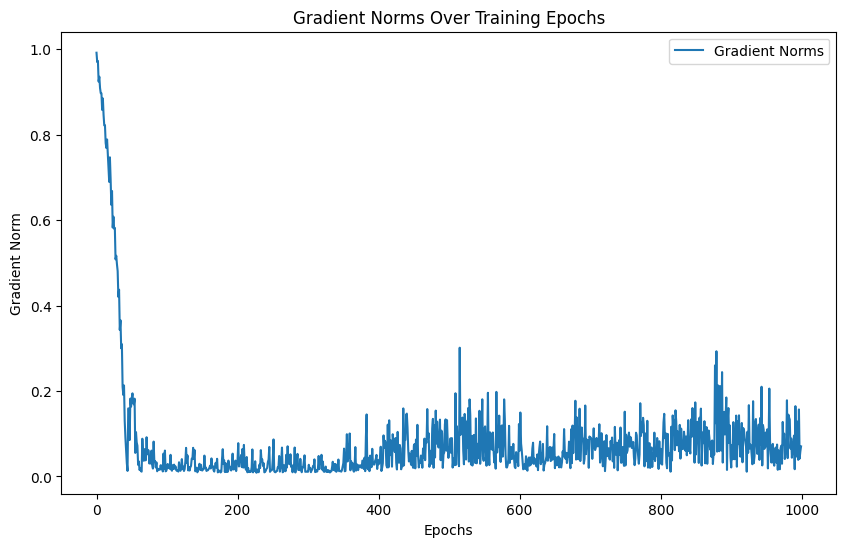

In [ ]:
# Plotting the gradient norms
plt.figure(figsize=(10, 6))
plt.plot(gradients, label='Gradient Norms')
plt.title('Gradient Norms Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()

## Eval

RMSE: 1.4881116562674839


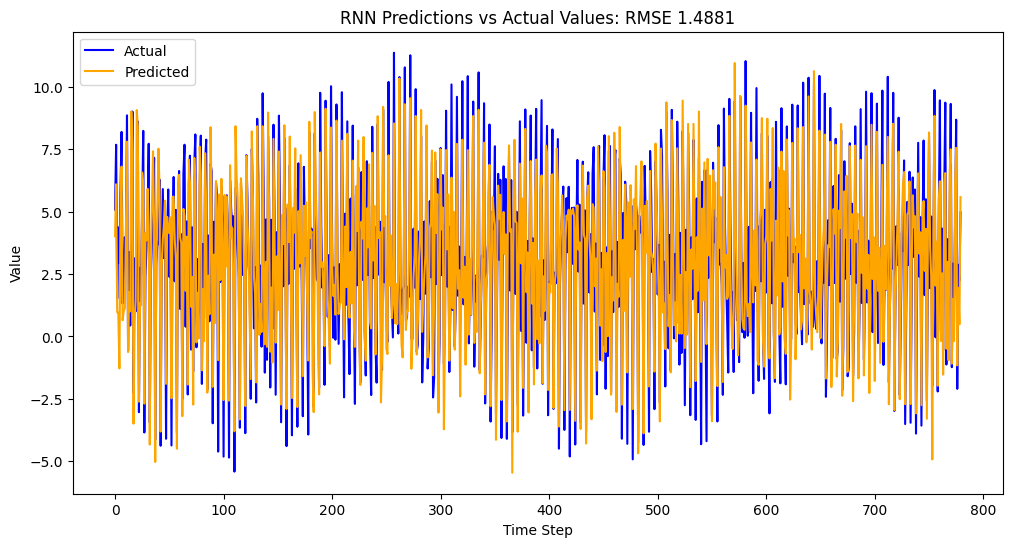

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_train_tensor)

y_hat = scaler_X.inverse_transform(predictions.numpy())
y = scaler_y.inverse_transform(y_train_tensor.reshape(-1, 1))

rmse = np.sqrt(np.mean((y - y_hat) ** 2))
print(f'RMSE: {rmse}')

import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual', color='blue')  # Actual values
plt.plot(y_hat, label='Predicted', color='orange')  # Predicted values
plt.title(f'RNN Predictions vs Actual Values: RMSE {rmse:.4f}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

RMSE: 8.881026315183735


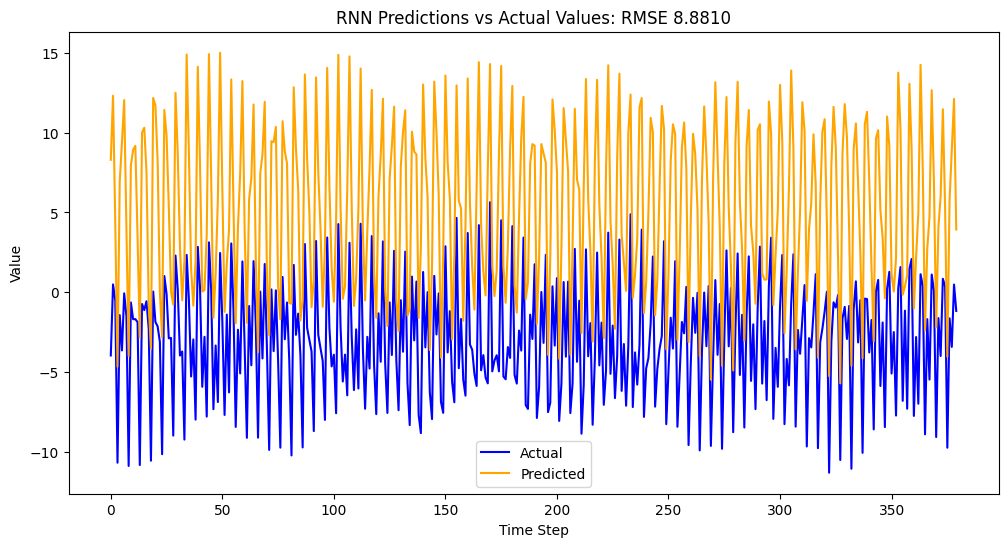

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_tensor)

y_hat = scaler_X.inverse_transform(predictions.numpy())
y = scaler_y.inverse_transform(y_test_tensor.reshape(-1, 1))

rmse = np.sqrt(np.mean((y - y_hat) ** 2))
print(f'RMSE: {rmse}')

import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual', color='blue')  # Actual values
plt.plot(y_hat, label='Predicted', color='orange')  # Predicted values
plt.title(f'RNN Predictions vs Actual Values: RMSE {rmse:.4f}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


**Lab Exercises:**

  -  Experiment with Hidden Sizes: Try changing the hidden layer size and observe how it affects the model performance.
  -  Use Real-World Data: Apply the RNN model to a real-world dataset (e.g., stock prices or weather data).
  -  Add More Layers: Try building a deeper RNN model by stacking multiple RNN layers and see how it affects the predictions.